In [311]:
%matplotlib inline
import pandas as pd
from glob import glob
import sys
import json
import os
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None  )
pd.set_option('display.max_colwidth', None)

from scipy.optimize import curve_fit

def samples_seen_from_str(samples):
    if samples.endswith("M"):
        samples = float(samples[:-1]) * 10**6
    elif samples.endswith("B"):
        samples = float(samples[:-1]) * 10**9
    elif samples.endswith("K"):
        samples = float(samples[:-1]) * 10**3
    return samples

def powlaw_irreducible(x, a, b, c):
    return a * np.power(x, b) + c


def powlaw_chinchilla(x, a, alpha, b, c):
    # x is tuple n, d
    return c + a * np.power(x[0], alpha) + b * np.power(x[1], alpha)

def powlaw(x, a, b):
    return a * np.power(x, b)


def curve_fit_powlaw_irreducible(xdata, ydata):
    # try many different fits and retain the best one as done in chinchilla
    a_p0 = [5e1, 5e2, 5e3]
    b_p0 = [-1e-1]
    c_p0 = [0.0]

    min_residual = float("inf")
    ret = None

    for a0 in a_p0:
        for b0 in b_p0:
            for c0 in c_p0:
                popt, pcov = curve_fit(
                    powlaw_irreducible,
                    xdata,
                    ydata,
                    p0=[a0, b0, c0],
                    maxfev=10000,
                )

                ydatafit = powlaw_irreducible(xdata, *popt)
                residuals = ydata - ydatafit
                curr_residual = (np.sum(residuals**2) / (residuals.size - 2)) ** 0.5

                if curr_residual < min_residual:
                    min_residual = curr_residual
                    ret = (popt, pcov, ydatafit)

    def func(x):
        a,b,c = ret[0]
        return (a*x**b+c)
    a,b,c = ret[0]
    return (a,b,c), func, f"Y = {a:.2f}*X^{b:.2f}+{c:.2f}"

def curve_fit_powlaw_quantile(xdata, ydata, q=0.1):
    from sklearn.linear_model import QuantileRegressor, LinearRegression
    if q is None:
        r = LinearRegression()
    else:
        r = QuantileRegressor(quantile=q, alpha=0, solver='highs-ds')
    print(r)
    log_xdata = np.log(xdata)
    log_ydata = np.log(ydata)
    r.fit(log_xdata.reshape((-1, 1)), log_ydata)
    def func(x):
        return (x**r.coef_[0]) * np.exp(r.intercept_)
    a, b = (r.intercept_, r.coef_[0])
    return (a,b), func, f"Y = {np.exp(a):.4f} x X^{b:.4f}"

In [469]:
%%time
!python build_results_dataframe.py

Done loading results
Added sugar crepe avg
CPU times: user 2.88 s, sys: 534 ms, total: 3.41 s
Wall time: 4min 38s


In [470]:
df = pd.read_csv("results.csv")
model_profile = pd.read_csv("model_profile.csv").set_index("model")

In [ ]:
df.m

In [258]:
df.samples_seen_scale_simple.unique()

array(['1.28M', '1.28B', '12.8M', '128M', '12.8B', '3B', '64M', '3M',
       '300M', '6.4M', '30M'], dtype=object)

array(['1.28M', '1.28B', '12.8M', '128M', '12.8B', '3B', '64M', '3M',
       '300M', '6.4M', '30M'], dtype=object)

In [471]:
df.columns

Index(['path', 'model', 'pretrain_dataset', 'downstream_dataset', 'epoch',
       'total_epochs', 'total_samples_seen', 'name', 'gflops_total',
       'samples_per_sec', 'samples_per_sec_per_gpu', 'global_batch_size',
       'training_time_hours', 'gpus', 'total_steps', 'task',
       'local_batch_size', 'warmup', 'lr', 'lr_scheduler', 'contrastive_loss',
       'caption_loss', 'namespace', 'eval_type', 'gpu_hours', 'image_acc',
       'text_acc', 'acc', 'acc1', 'acc5', 'mean_per_class_recall',
       'image_retrieval_recall@5', 'text_retrieval_recall@5', 'name_epoch',
       'model_simple', 'model_simple_namespace', 'samples_seen_scale_simple'],
      dtype='object')

In [472]:
print("Number of unique models: ", len(df.name.unique()))
print("Number of unique checkpoints: ", len(df.name_epoch.unique()))
print("Number of downstream datasets", len(df.downstream_dataset.unique()))
print("Number of evaluations", len(df))

Number of unique models:  1575
Number of unique checkpoints:  39853
Number of downstream datasets 12
Number of evaluations 150935


In [322]:
model_profile.head()

,image_size,image_width,text_width,embed_dim,mparams,image_mparams,text_mparams,gflops,image_gflops,text_gflops
model,,,,,,,,,,
ViT-S-32-alt,224,384.0,256.0,256.0,43.22,22.59,20.63,3.56,2.29,1.27
ViT-S-32,224,384.0,384.0,384.0,63.09,22.64,40.44,5.66,2.29,3.38
ViT-M-32-alt,224,512.0,384.0,384.0,80.07,39.63,40.44,7.37,3.99,3.38
ViT-M-32,224,512.0,512.0,512.0,103.12,39.69,63.43,9.95,3.99,5.96
ViT-S-16-alt,224,384.0,256.0,256.0,42.40,21.76,20.63,10.47,9.20,1.27


# Throughput 

In [473]:
df.model.unique()

array(['mammut_ViT-M-32', 'mammut_ViT-L-14', 'mammut_ViT-S-32',
       'mammut_ViT-B-32', 'mammut_ViT-S-16', 'mammut_ViT-H-14',
       'mammut_ViT-B-16', 'ViT-B-32', 'ViT-S-16', 'ViT-S-32',
       'coca_ViT-S-32', 'ViT-M-32', 'ViT-B-16-text-plus', 'coca_ViT-L-14',
       'coca_ViT-M-32', 'coca_ViT-S-16', 'coca_ViT-B-32', 'coca_ViT-B-16',
       'ViT-L-14', 'ViT-H-14', 'ViT-S-32-alt', 'ViT-B-16', 'ViT-M-16',
       'ViT-M-16-alt', 'ViT-M-32-alt'], dtype=object)

Text(0, 0.5, 'mparams')

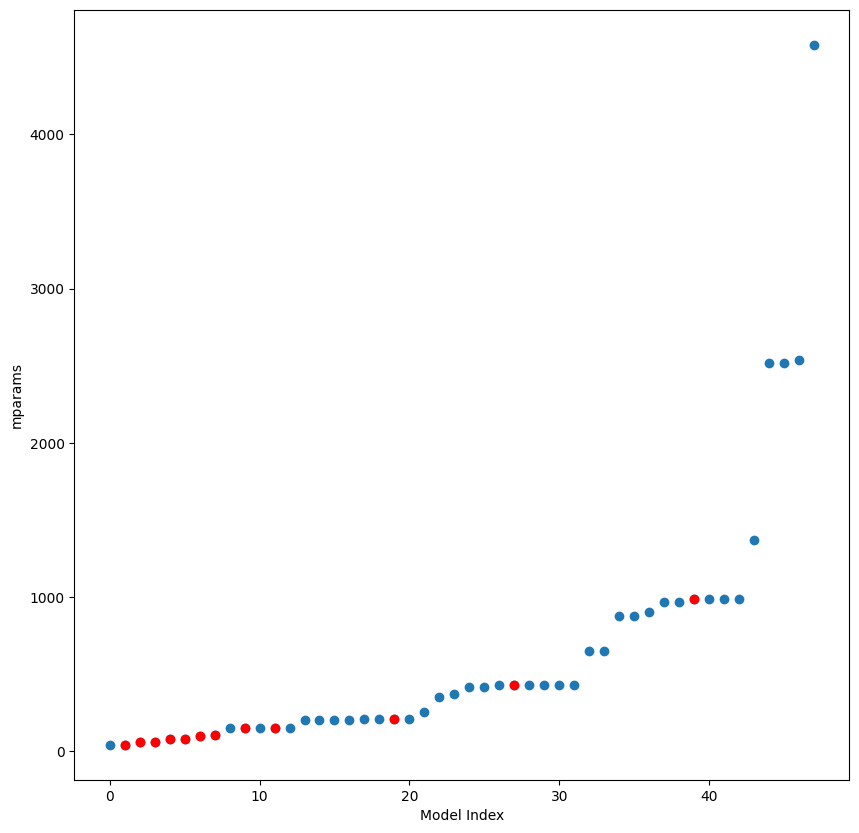

In [474]:
mp = model_profile.reset_index().copy()
mp = mp[mp["model"].str.startswith("ViT")]
S = "mparams"
mp = mp.sort_values(S)
mp["nb"] = np.arange(len(mp))

fig = plt.figure(figsize=(10, 10))

#mp.plot.scatter(x="nb", y="gflops")
plt.scatter(mp.nb, mp[S])

m = mp[mp.model.isin(df.model.unique())]
plt.scatter(m.nb, m[S], c='red')
plt.xlabel("Model Index")
plt.ylabel(S)

In [335]:
model_profile.index

Index(['ViT-S-32-alt', 'ViT-S-32', 'ViT-M-32-alt', 'ViT-M-32', 'ViT-S-16-alt',
       'ViT-S-16', 'ViT-B-32', 'ViT-B-32-quickgelu', 'convnext_tiny',
       'ViT-B-32-256',
       ...
       'mammut_ViT-H-14', 'coca_ViT-S-32', 'coca_ViT-S-16', 'coca_ViT-M-32',
       'coca_ViT-B-16', 'ViT-SO150M-14-smaller-text', 'ViT-SO150M-14',
       'ViT-SO400M-14', 'sg_cap_ViT-B-32', 'sg_cap_ViT-B-16'],
      dtype='object', name='model', length=102)

<Axes: xlabel='model_s', ylabel='normalized_samples_per_sec_per_gpu'>

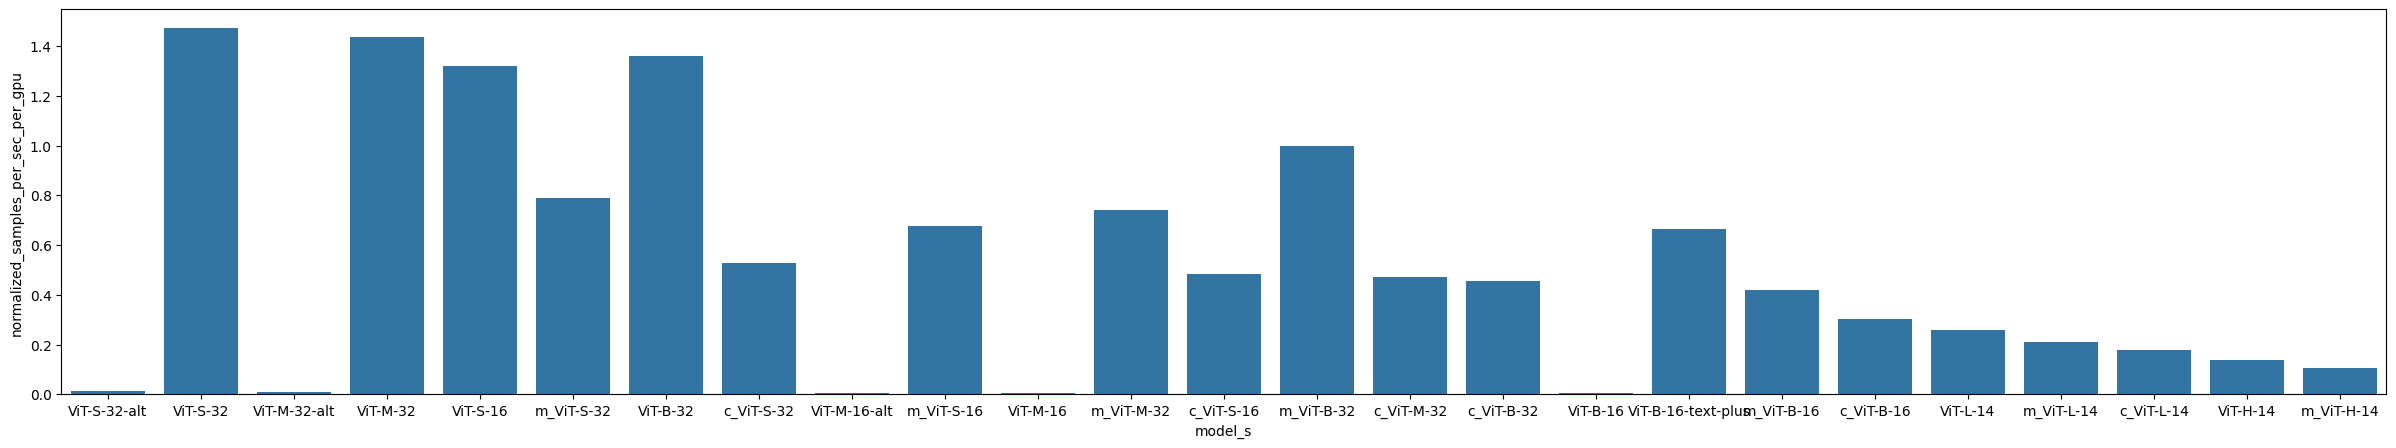

In [475]:
fig = plt.figure(figsize=(30, 5))
d = df.copy()
d["mparams"] = d.model.apply(lambda m:model_profile.loc[m].mparams)
d["gflops_model"] = d.model.apply(lambda m:model_profile.loc[m].gflops)

d["model_s"] = d.model.apply(lambda m:m.replace("mammut", "m").replace("coca", "c"))

archs = d.model_s.unique()

archs = sorted(archs, key=lambda k:model_profile.loc[k.replace("m", "mammut").replace("c", "coca")].gflops)

d["normalized_samples_per_sec_per_gpu"] = d["samples_per_sec_per_gpu"] / (d["local_batch_size"] * d["gpus"]) 
sns.barplot(x="model_s", y="normalized_samples_per_sec_per_gpu", data=d, order=archs, estimator=np.max)

In [476]:
d = df.copy()
d["normalized_samples_per_sec_per_gpu"] = d["samples_per_sec_per_gpu"] / (d["local_batch_size"] * d["gpus"]) 
d.groupby("model_simple_namespace").max("samples_per_sec_per_gpu").samples_per_sec_per_gpu.sort_values()

model_simple_namespace
ViT-H-14_mammut              55.467589
ViT-H-14_cap                 65.918173
ViT-H-14_clip                74.115664
ViT-L-14_coca               107.178987
ViT-L-14_mammut             118.440348
ViT-L-14_cap                135.658584
ViT-L-14_clip               149.465855
ViT-B-16_coca               195.494934
ViT-B-16_mammut             252.852082
ViT-B-16_cap                294.591618
ViT-B-32_coca               313.512217
ViT-M-32_coca               327.108849
ViT-S-16_coca               338.673007
ViT-S-32_coca               380.128967
ViT-B-16_clip               415.107656
ViT-B-16-text-plus_clip     436.032583
ViT-S-16_mammut             480.001876
ViT-B-32_mammut             491.509814
ViT-M-32_mammut             520.326020
ViT-S-16_cap                528.224919
ViT-B-32_cap                554.248881
ViT-M-16_clip               566.697109
ViT-M-16-alt_clip           576.878047
ViT-M-32_cap                586.268684
ViT-S-32_mammut             591.415351
Vi

# DataComp Recap (recaptioned) vs DataComp results

In [477]:
#ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"
#ds, metric = "winoground", "acc"

pretrain_datasets = df.pretrain_dataset.unique()
print(pretrain_datasets)

d = df[~df.pretrain_dataset.isna()].copy()
d["name_wo_ds"] = d.name.apply(lambda n:n.replace("datacomp_recap", "").replace("datacomp", ""))
ns = "cap"
d = d[d.namespace==ns]
df_recap = d[d.pretrain_dataset=="datacomp_1b_recap"]
df_orig = d[d.pretrain_dataset=="datacomp_1b"]
print(df_recap.namespace.unique())
print(df_orig.namespace.unique())

d = df_recap
d = d[d.epoch == d.total_epochs]
d = d[d.downstream_dataset == ds]


do = df_orig
do = do[do.epoch == do.total_epochs]
do = do[do.downstream_dataset == ds]
d = pd.merge(d, do, on="name_wo_ds", suffixes=("_recap", "_orig"))
d[["name_recap", f"{metric}_recap", f"{metric}_orig"]]

['datacomp_1b' 'datacomp_1b_recap']
['cap']
['cap']


,name_recap,image_acc_recap,image_acc_orig
0,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1950,0.1550
1,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2125,0.1550
2,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2325,0.1575
3,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2000,0.1375
4,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2000,0.1400
5,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1900,0.1700
6,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1925,0.1700
7,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.1900,0.1550
8,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2175,0.1350
9,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,0.2175,0.1625


# Results per checkpoint

In [478]:
df[df.downstream_dataset=="imagenet1k"].sort_values(by="acc1", ascending=False).head()[["acc1", "name", "namespace", "epoch"]]

,acc1,name,namespace,epoch
107716,0.80342,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,99
107692,0.80338,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,100
107580,0.80298,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
107715,0.80294,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,98
80465,0.80232,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,98


In [479]:
d = df
d = d[d.downstream_dataset=="imagenet1k"]
d = d[d.epoch==d.total_epochs]
d = d[d.samples_seen_scale_simple=="12.8B"]
d = d[d.model_simple=="ViT-L-14"]
d = d.sort_values(by="acc1", ascending=False)[["acc1", "name", "namespace"]]
d

,acc1,name,namespace
107692,0.803380,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
95860,0.802260,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
80442,0.801680,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
71927,0.801520,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut
49579,0.800700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
106074,0.800280,datacomp_s12.8B_bs_360960_mammut_ViT-L-14_ep100_lr0.0035_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n320_bs282_sigFalse,mammut
84490,0.799060,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut
86814,0.798600,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.002_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n176_bs128_sigFalse,mammut
80242,0.796100,datacomp_s12.8B_bs_90112_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n176_bs128_sigFalse,mammut
87014,0.793400,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut


In [480]:
df[df.downstream_dataset=="sugar_crepe"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
147562,0.910728,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19
147570,0.910250,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
147567,0.905062,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,18
149844,0.903457,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,20
147580,0.903354,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,17


In [481]:
df[df.downstream_dataset=="sugar_crepe/swap_obj"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
71592,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,92
71814,0.869919,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,100
71924,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,99
72037,0.865854,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,97
8236,0.865854,datacomp_s1.28B_bs_32640_mammut_ViT-H-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n48_bs170_sigFalse_consw0_cw1,cap,19


In [482]:
df[df.downstream_dataset=="winoground"].sort_values(by="acc", ascending=False).head()[["acc", "name", "namespace", "epoch"]]

,acc,name,namespace,epoch
49302,0.1425,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,88
4495,0.1400,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
4381,0.1375,datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,20
49285,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,97
49200,0.1375,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,93


In [483]:
df[df.downstream_dataset=="winoground"].sort_values(by="text_acc", ascending=False).head(20)[["text_acc", "name", "namespace", "epoch"]]

,text_acc,name,namespace,epoch
71670,0.3800,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,40
71944,0.3700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,70
71787,0.3700,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,93
71980,0.3650,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,94
71941,0.3600,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,91
49739,0.3575,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse,mammut,63
71635,0.3550,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,86
71874,0.3550,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,82
71742,0.3525,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,80
71802,0.3525,datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.003_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n256_bs176_sigFalse,mammut,45


In [484]:
df[df.downstream_dataset=="winoground"].sort_values(by="image_acc", ascending=False).head()[["image_acc", "name", "namespace", "epoch"]]

,image_acc,name,namespace,epoch
9837,0.2475,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,19
9748,0.2425,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,16
22009,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w10000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,18
10086,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,6
2076,0.2350,datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w4000_gc1_n16_bs256_sigFalse_consw0_cw1,cap,13


# Specific Training Curves

['cap']
       epoch      acc1
31065      1  0.001384
30423      2  0.004153
31021      3  0.014834
31070      4  0.029866
30814      5  0.031843
30843      6  0.016614
30535      7  0.001780
30427      8  0.000989
30579      9  0.000989
30744     10  0.000989
30925     11  0.000989
30798     12  0.000989
30824     13  0.000989
30495     14  0.000989
31010     15  0.000989
30389     16  0.000989
31149     17  0.000989
30482     18  0.000989
30511     19  0.003560
31028     20  0.191060
30447     21  0.403283
30831     22  0.383307
30430     23  0.421479
30498     24  0.436116
30973     25  0.442049
30380     26  0.408426
31107     27  0.446203
30361     28  0.435324
31239     29  0.450949
30605     30  0.448180
30914     31  0.437104
30837     32  0.462025
30638     33  0.471915
30436     34  0.449960
31106     35  0.486551
31248     36  0.493473
31074     37  0.482199
31118     38  0.485562
30597     39  0.485759
30654     40  0.493473
30440     41  0.473892
30844     42  0.503362
304

Text(0.5, 1.0, 'imagenet1k acc1 generative_zeroshot_classification')

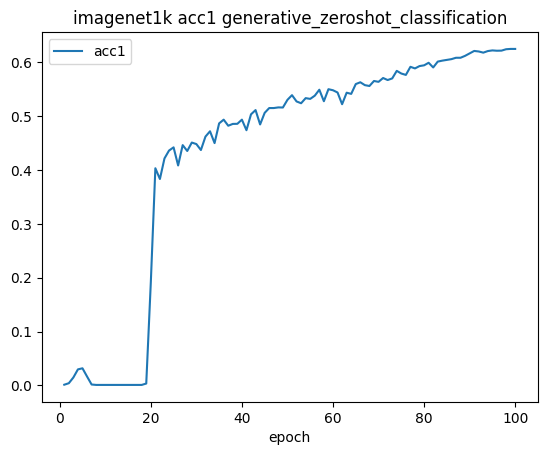

In [485]:
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1"
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0025_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"
#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.0015_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n256_bs176_sigFalse_consw0_cw1"

#ds, metric, task = "winoground", "image_acc", "generative_image_caption_selection"
#ds, metric, task = "winoground", "text_acc", "generative_image_caption_selection"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "generative_image_caption_selection"
#ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
ds, metric, task = "imagenet1k", "acc1", "generative_zeroshot_classification"

d = df

d = d[d.name==name]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
print(d.namespace.unique())
print(d[["epoch", metric]])
#print(d[["epoch", metric]])
d.plot(x="epoch", y=metric)
#d[["epoch", metric]]
plt.title(f"{ds} {metric} {task}")

Text(0.5, 1.0, 'winoground generative_image_caption_selection text_acc')

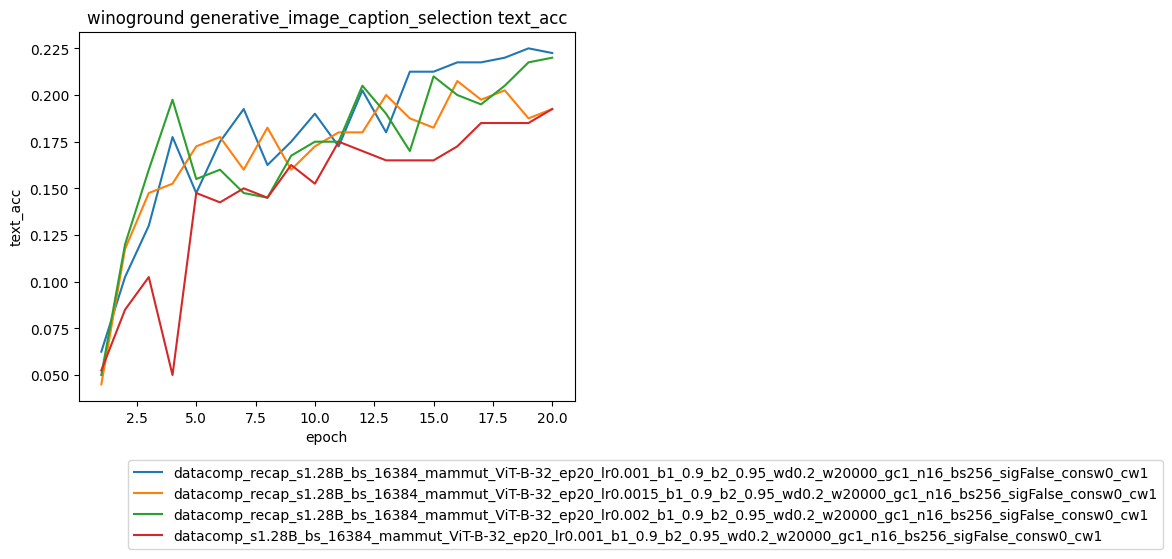

In [486]:
ds, metric, task = "winoground", "text_acc", "generative_image_caption_selection"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "generative_image_caption_selection"
#ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "imagenet1k", "acc1", "generative_zeroshot_classification"


#name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
#name = "datacomp_s1.28B_bs_16384_mammut_ViT-L-14_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w15000_gc1_n16_bs256_sigFalse_consw0_cw1"
names = [
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.002_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_recap_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.0015_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
    "datacomp_s1.28B_bs_16384_mammut_ViT-B-32_ep20_lr0.001_b1_0.9_b2_0.95_wd0.2_w20000_gc1_n16_bs256_sigFalse_consw0_cw1",
]

d = df

d = d[d.name.isin(names)]
d = d[d.task == task]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="name", data=d)
#d[["epoch", metric]]
plt.legend(loc=(.1,-.4))
plt.title(f"{ds} {task} {metric}")

Text(0.5, 1.0, 'winoground')

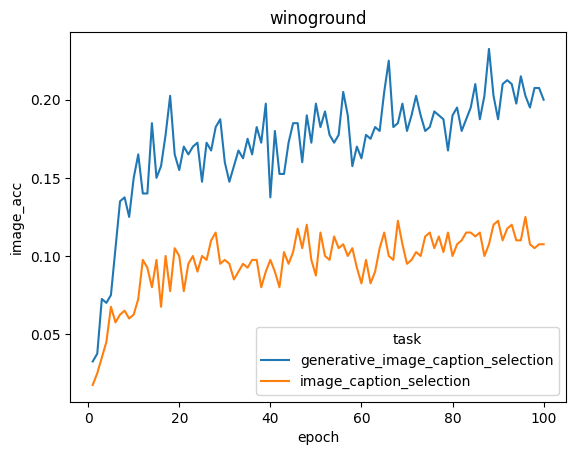

In [487]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "image_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)
plt.title(f"{ds}")

Text(0.5, 1.0, 'winoground')

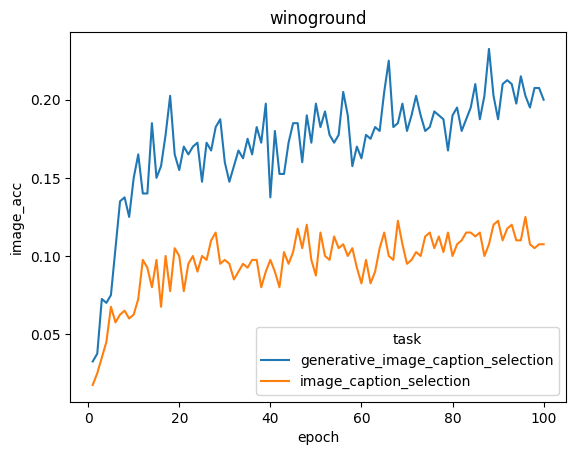

In [52]:
name = "datacomp_s12.8B_bs_180224_mammut_ViT-L-14_ep100_lr0.001_b1_0.9_b2_0.95_wd0.2_w6000_gc1_n256_bs176_sigFalse"
ds = "winoground"
metric = "image_acc"

d = df

d = d[d.name==name]
d = d[d.downstream_dataset == ds]
d = d.sort_values(by="epoch")
sns.lineplot(x="epoch", y=metric, hue="task", data=d)
plt.title(f"{ds}")

# Full results table

['1.28M' '1.28B' '12.8M' '128M' '12.8B' '3B' '64M' '3M' '300M' '6.4M'
 '30M']


In [488]:
#ds, metric = "imagenet1k", "acc1"
ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"
d = df
d = d[d.pretrain_dataset=="datacomp_1b"]
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
#d = d[d.task == "generative_image_caption_selection"]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-1])].gflops)

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
d = d.loc[index]

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,6.4M,12.8M,30M,64M,128M,300M,1.28B,3B,12.8B
model_simple_namespace,,,,,,,,,,,
ViT-S-32_cap,0.670732,NaN,NaN,0.715447,NaN,NaN,0.747967,NaN,0.804878,NaN,NaN
ViT-S-32_clip,0.516260,0.540650,NaN,0.581301,0.577236,NaN,0.621951,0.577236,0.589431,NaN,NaN
ViT-S-32_coca,0.650406,NaN,NaN,0.707317,0.735772,NaN,0.715447,0.776423,NaN,NaN,NaN
ViT-S-32_mammut,0.658537,0.682927,0.691057,0.715447,0.743902,0.747967,0.747967,0.772358,0.735772,NaN,NaN
ViT-M-32_cap,0.670732,NaN,NaN,0.719512,NaN,NaN,0.784553,NaN,0.825203,NaN,NaN
ViT-M-32_clip,0.504065,0.556911,NaN,0.552846,0.569106,NaN,0.573171,0.577236,0.621951,0.601626,NaN
ViT-M-32_coca,NaN,0.654472,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ViT-M-32_mammut,0.682927,0.674797,0.686992,0.715447,0.735772,0.776423,0.768293,0.800813,0.760163,NaN,NaN
ViT-S-16_cap,0.691057,NaN,NaN,0.703252,NaN,NaN,0.768293,NaN,0.808943,NaN,NaN


# Const-LR results

In [489]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"
d = df.copy()
d["model_simple_namespace_scheduler"] = d.apply(lambda r:f"{r.model_simple_namespace}_{r.lr_scheduler}", axis=1)
d = d[d.pretrain_dataset == "datacomp_1b"]
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d = d[d.lr_scheduler.isin(["cosine", "const-cooldown"])]
d = d[d.namespace == "clip"]
#d = d[d.task.str.contains("generative")]
#print(len(d))
#d = d[d.eval_type == eval_type]
d = d.sort_values(by=metric, ascending=False)
vars=("samples_seen_scale_simple", "model_simple_namespace_scheduler")
d = d.drop_duplicates(subset=vars, keep="first")
d = pd.pivot(
    d,
    index="samples_seen_scale_simple",
    columns=("model_simple_namespace_scheduler"),
    values=metric,
)

cols = d.columns
cols = sorted(cols, key=lambda k:model_profile.loc["_".join(k.split("_")[:-2])].gflops)
#cols = [c  for c in cols if "cap" not in c and "coca" not in c and "H-14" not in c and "plus" not in c]

d = d[cols]
index = sorted(d.index, key=lambda k:samples_seen_from_str(k))
#index = ['1.28B']
d = d.loc[index]
#print(index)
#d = d.dropna(axis=0)
#d.T

dl = d.T.copy()
dl = dl.round(2)
s=(dl.to_latex(float_format="%.2f"))
s = s.replace("NaN", "-")
s = s.replace("_", " ")
s = s.replace("coca", "CoCa")
s = s.replace("cap", "Cap")
s = s.replace("mammut", "MaMMUT")
s = s.replace("clip", "CLIP")
#print(s)
d
d.T

samples_seen_scale_simple,1.28M,3M,12.8M,30M,128M,300M,1.28B,3B,12.8B
model_simple_namespace_scheduler,,,,,,,,,
ViT-S-32-alt_clip_const-cooldown,NaN,NaN,NaN,NaN,0.07002,NaN,0.48842,0.53172,NaN
ViT-S-32_clip_const-cooldown,NaN,NaN,NaN,NaN,0.07572,NaN,0.51138,0.55742,0.59586
ViT-S-32_clip_cosine,0.01304,0.03032,0.10208,0.18664,0.35402,0.43956,0.53118,0.55864,NaN
ViT-M-32-alt_clip_const-cooldown,NaN,NaN,NaN,NaN,0.08070,NaN,0.55078,0.59182,NaN
ViT-M-32_clip_const-cooldown,NaN,NaN,NaN,NaN,0.09260,NaN,0.56184,0.60714,0.64212
ViT-M-32_clip_cosine,0.01396,0.03240,0.10504,0.20074,0.38302,0.47810,0.57304,0.60788,NaN
ViT-S-16_clip_const-cooldown,NaN,NaN,NaN,NaN,0.09390,NaN,0.58546,0.62614,0.66382
ViT-S-16_clip_cosine,0.02000,0.04404,0.13388,0.23700,0.42338,0.50486,0.59574,0.62844,NaN
ViT-B-32_clip_const-cooldown,NaN,NaN,NaN,NaN,0.10768,NaN,0.60546,0.64770,0.68860


In [490]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "winoground", "image_acc"
#ds, metric = "winoground", "text_acc"
d = df.copy()
d["model_simple_namespace_scheduler"] = d.apply(lambda r:f"{r.model_simple_namespace}_{r.lr_scheduler}", axis=1)
d = d[d.pretrain_dataset == "datacomp_1b"]
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
d = d[d.lr_scheduler == "const-cooldown"]
d = d[d.model == "ViT-B-32"]
d = d.sort_values(by=metric, ascending=False)
d["train_num_samples"] = d.apply(lambda r:r["total_samples_seen"] / r["total_epochs"], axis=1)    
d[["name", "acc1", "samples_seen_scale_simple", "total_samples_seen", "global_batch_size", "warmup", "train_num_samples"]]

,name,acc1,samples_seen_scale_simple,total_samples_seen,global_batch_size,warmup,train_num_samples
139426,cooldown_s12.8B_cdpow0.5,0.68860,12.8B,12800000000,90624,4000,12800000.0
139926,cooldown_s12.8B,0.68510,12.8B,12800000000,90624,4000,12800000.0
145498,cooldown_s12.8B_cdpow0.5,0.67866,12.8B,12800000000,90624,4000,12800000.0
145998,cooldown_s12.8B,0.67832,12.8B,12800000000,90624,4000,12800000.0
140582,cooldown_s3B_cdpow0.5,0.64770,3B,2995200000,90624,4000,12800000.0
140416,cooldown_s3B,0.64746,3B,2995200000,90624,4000,12800000.0
146654,cooldown_s3B_cdpow0.5,0.64650,3B,2995200000,90624,4000,12800000.0
146488,cooldown_s3B,0.64212,3B,2995200000,90624,4000,12800000.0
146532,cooldown_s1.28B_cdpow0.5,0.60546,1.28B,1280000000,90624,4000,12800000.0
146358,cooldown_s1.28B,0.60270,1.28B,1280000000,90624,4000,12800000.0


# Comparison between Log-likehood and Similarity based evaluation

In [491]:
df.pretrain_dataset.unique()

array(['datacomp_1b', 'datacomp_1b_recap'], dtype=object)

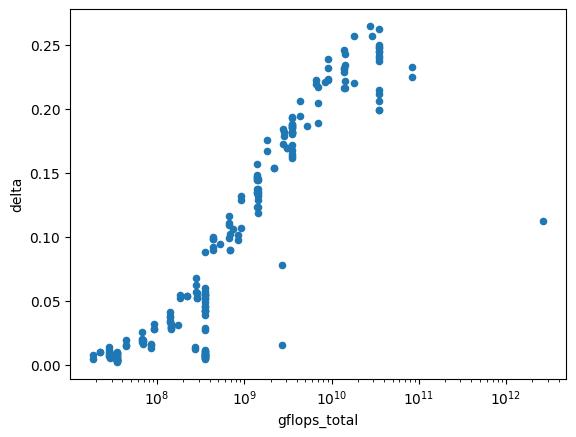

,generative_zeroshot_classification,zeroshot_classification,delta,gflops_total
50,0.688739,0.80070,0.111961,2.685952e+12
150,0.429188,0.65380,0.224612,8.398848e+10
151,0.398318,0.63082,0.232502,8.398848e+10
1,0.404991,0.61630,0.211309,3.499520e+10
0,0.401335,0.61618,0.214845,3.499520e+10


In [492]:
ds, metric, task = "imagenet1k", "acc1", "zeroshot_classification"
#ds, metric, task = "sugar_crepe/swap_obj", "acc", "image_caption_selection"
#ds, metric, task = "winoground", "text_acc", "image_caption_selection"
#ds, metric, task = "winoground", "image_acc", "image_caption_selection"

d = df.copy()
d = d[d.pretrain_dataset=="datacomp_1b"]


gtask = "generative_" + task
d = d[d.downstream_dataset==ds]
d = d[d.epoch==d.total_epochs]
di = d[d.task==task]
d["name_wo_task"] = d.apply(lambda r:r["name"].replace("generative_", ""), axis=1)
d = d.drop_duplicates(subset=["name_wo_task", "task"], keep="first")    
d = pd.pivot(
    d,
    index="name_wo_task",
    columns=("task"),
    values=metric,
)
d = d.dropna(axis=0)
d["delta"] = (d[task] - d[gtask]).abs()
d = pd.merge(d, di, left_on='name_wo_task', right_on="name")
d = d.sort_values(by=task, ascending=False)#.head()
#print(d[[gtask, task, "delta", "gflops_total"]].head())
d.plot(x="gflops_total", y="delta", kind="scatter")
plt.xscale('log',base=10)
plt.show()
d[[gtask, task, "delta", "gflops_total"]].head()

# Scaling law figures

In [493]:
import torch
import math
def monotonically_decreasing(x):
    m = []
    minval = float("inf")
    for xi in x:
        if xi < minval:
            m.append(True)
            minval = xi
        else:
            m.append(False)
    return np.array(m)

def monotonically_increasing(x):
    m = []
    maxval = float("-inf")
    for xi in x:
        if xi > maxval:
            m.append(True)
            maxval = xi
        else:
            m.append(False)
    return np.array(m)


import networkx as nx

def create_graph(X, eps):
    """
    Create an undirected NetworkX graph G where each of the N elements
    in X is a node, and edges connect pairs (i, j) if |X[i] - X[j]| < eps.
    """
    N = len(X)
    G = nx.Graph()
    
    # Add nodes
    G.add_nodes_from(range(N))
    
    # Add edges based on threshold
    for i in range(N):
        for j in range(i + 1, N):
            if abs(X[i] - X[j]) < eps:
                G.add_edge(i, j)
    
    return G

def group_vals(X, Y, eps=1e-5):
    X = X.copy()
    Y = Y.copy()
    G = create_graph(X, eps)
    XX = []
    YY = []
    for c in nx.connected_components(G):
        c = list(c)
        group_x = X[c]
        group_y = Y[c]
        
        
        XX.append(group_x[group_y.argmin()])
        YY.append(group_y.min())
        
        #Y[c] = minvalue
    XX = np.array(XX)
    YY = np.array(YY)
    
    inds = np.argsort(XX)
    XX = XX[inds]
    YY = YY[inds]
    
    return XX, YY

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 7.5073 x X^-0.1094
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 14.9698 x X^-0.1544
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 5.2989 x X^-0.0900
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 17.6460 x X^-0.1573
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 4.7211 x X^-0.0854
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 22.3274 x X^-0.1702
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
Y = 8.9545 x X^-0.1241


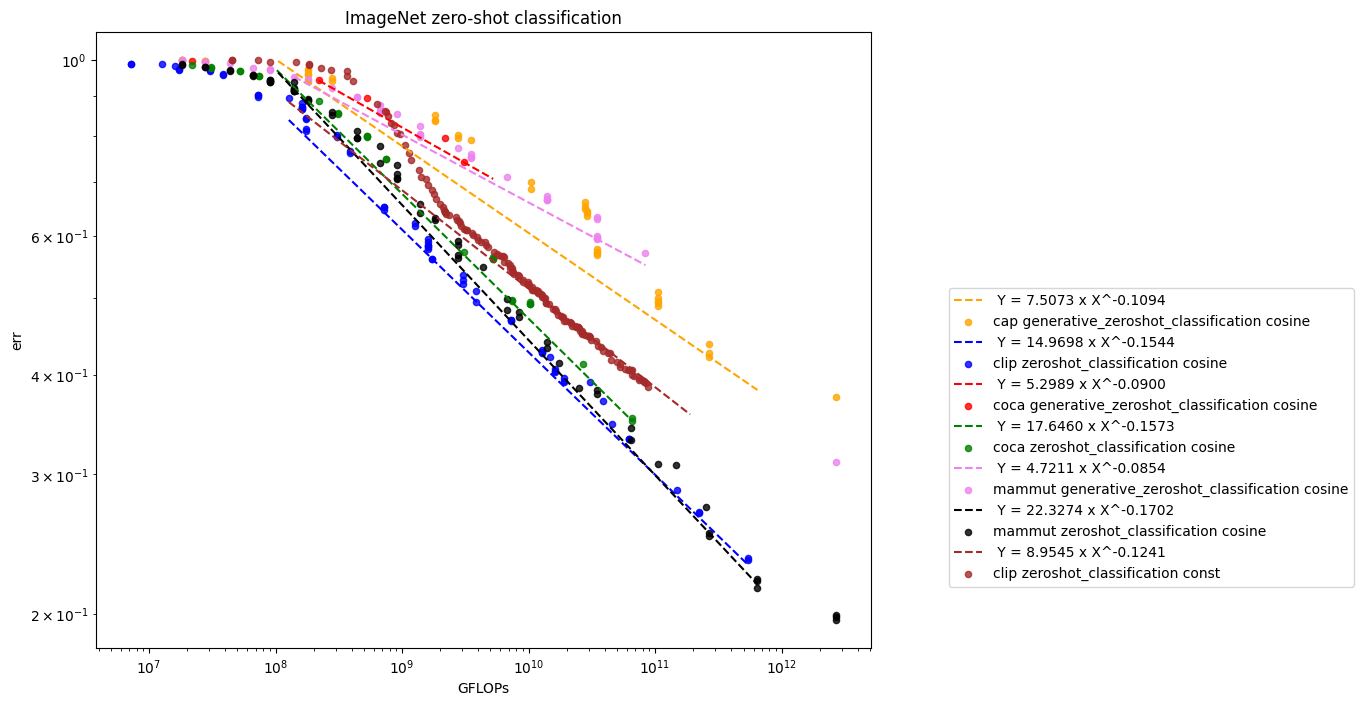

In [494]:
ds, metric = "imagenet1k", "acc1"
#scheduler = "const"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
fig = plt.figure(figsize=(10, 8))
I = 0
colors = ["orange", "blue", "red", "green", "violet", "black", "brown", "pink", "gray", "cyan"]
curves = {}
for scheduler in ("cosine", "const"):
    D = df
    D = D[D.pretrain_dataset == "datacomp_1b"]
    if scheduler != "const":
        D = D[D.epoch==D.total_epochs]
    D = D[D.downstream_dataset==ds]
    D = D[D.lr_scheduler==scheduler]
    D = D[~D[metric].isna()]
    #D = D[D.namespace == "clip"]
    
    
    #print(D)
    for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
        #if "generative"  in name[1]:
        #    continue
        #if "coca" in name[0]:
        #    continue
        #if "mammut" not in name[0]:
        #    continue
        R = rows[rows.downstream_dataset==ds]
        R = R[~R[metric].isna()]
        if len(R) == 0:
            continue
        if scheduler == "const":
            R["model_gflops"] = R.model.apply(lambda m:model_profile.loc[m].gflops)
            R["gflops_total"] = R.epoch * 12.8e6 * R.model_gflops
        R = R.sort_values(by="gflops_total")
        
        X = (R["gflops_total"]).values
        Y = 1-(R[metric]).values


        color = colors[I]
        I+=1
        #m  = X>=10**9
        m = (X>=10**8) & (X < 10**12)
        #m = (X<10**12)
        #m = (X>0)  & (Y<1)
        #m = X>0
        #print(np.unique(X))
        #for xi in np.unique(X):
        #    minval = Y[X==xi].min()
        #    Y[X==xi] = minval
        #m=(Y<=0.9) & (Y>0)
        coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
        
        curves[ (name[0], name[1], scheduler)] = func

        print(eq)
        plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
        
        #X = X[Y<1]
        #Y = Y[Y<1]
        m = monotonically_decreasing(Y)
        #m = X>0
        plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]} {scheduler}", c=color, s=20.0, alpha=0.8)

        #plt.plot(X[m], Y[m], linestyle='dashed', c=color)
plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
plt.legend(loc=(1.1,.1))

#plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

In [456]:
func = curves[ ("mammut", "zeroshot_classification", "cosine") ]
gf = model_profile.loc["ViT-L-14"].gflops * 12.8e9
1-func(gf)

0.8236762610498706

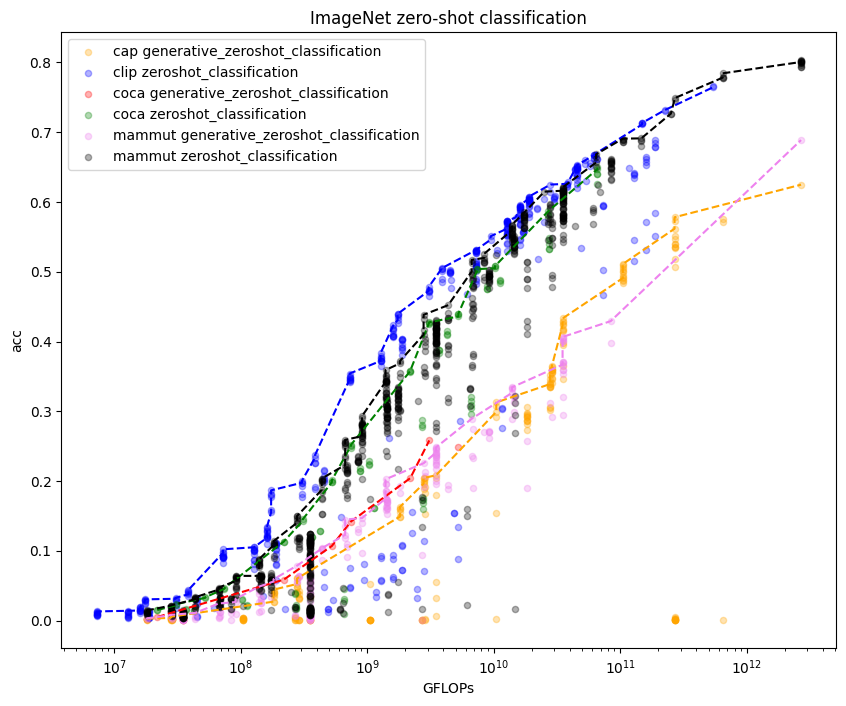

In [495]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
#ds, metric = "sugar_crepe", "acc"
#ds, metric = "winoground", "acc"

D = df
D = D[D.pretrain_dataset == "datacomp_1b"]

D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby(["namespace", "task"])):    
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows[rows.downstream_dataset==ds]
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    #Y = 1-(R[metric]).values
    Y = (R[metric]).values

    color = colors[I]
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)
    #coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    #plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)
    
    #X = X[Y<1]
    #Y = Y[Y<1]

    m = X>0
    plt.scatter(X[m], Y[m], label=f"{name[0]} {name[1]}", c=color, s=20.0, alpha=0.3)
    m = monotonically_increasing(Y)
    plt.plot(X[m], Y[m], linestyle='dashed', c=color)
    
plt.xscale('log')
#plt.yscale("log")

plt.xlabel("GFLOPs")

#plt.ylabel("err")  
plt.ylabel("acc")
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

In [496]:
import matplotlib.colors as mcolors
# Define the start and end colors
start_color = "lightblue"  # or a hex like "#ADD8E6"
end_color = "darkblue"         # or a hex like "#0000FF"

# Create the colormap
blue_cmap = mcolors.LinearSegmentedColormap.from_list(
    "light_to_dark_blue", [start_color, end_color]
)
blue_cmap(200)

cmap = plt.get_cmap("Blues")


In [351]:
np.log10(df.gflops_total.min()), np.log10(df.gflops_total.max())

(6.86002640083614, 12.429098247230165)

In [253]:
gflops_grid = np.logspace(7, 12, 10)
for g in gflops_grid:

    for model in D.model.unique():
        mg = model_profile.loc[model].gflops
        print("total", g, model, "with samples seen", (g/mg) / 10**6, "M")

total 10000000.0 ViT-S-16 with samples seen 0.794912559618442 M
total 10000000.0 ViT-S-32 with samples seen 1.7667844522968197 M
total 10000000.0 ViT-M-32 with samples seen 1.0050251256281408 M
total 10000000.0 ViT-B-32 with samples seen 0.6765899864682003 M
total 35938136.63804626 ViT-S-16 with samples seen 2.856767618286666 M
total 35938136.63804626 ViT-S-32 with samples seen 6.349494105661883 M
total 35938136.63804626 ViT-M-32 with samples seen 3.611873028949373 M
total 35938136.63804626 ViT-B-32 with samples seen 2.431538338162805 M
total 129154966.50148827 ViT-S-16 with samples seen 10.266690500913217 M
total 129154966.50148827 ViT-S-32 with samples seen 22.818898675174605 M
total 129154966.50148827 ViT-M-32 with samples seen 12.980398643365657 M
total 129154966.50148827 ViT-B-32 with samples seen 8.738495703754282 M
total 464158883.3612773 ViT-S-16 with samples seen 36.896572604235075 M
total 464158883.3612773 ViT-S-32 with samples seen 82.00686985181578 M
total 464158883.3612773

<Axes: xlabel='gflops', ylabel='model_gflops'>

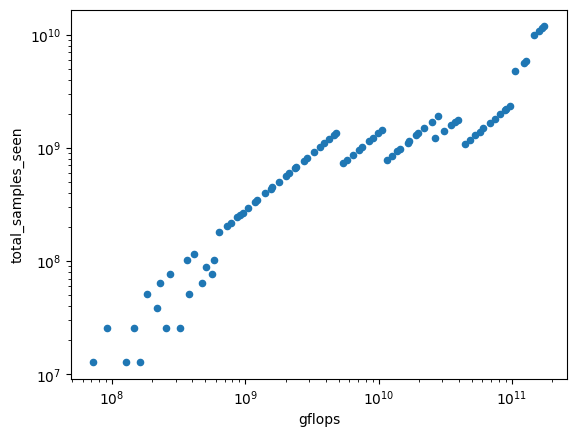

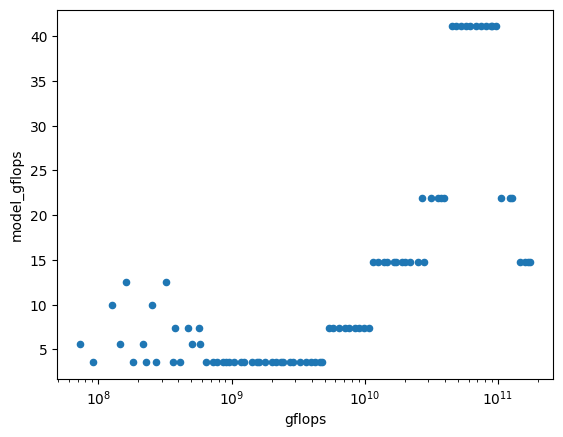

In [498]:

ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
#ds, metric = "imagenet1k", "contrastive_loss"
D = df.copy()
D = D[D.pretrain_dataset == "datacomp_1b"]
#D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
D = D[D.lr_scheduler == "const"]
D = D[D.namespace == "clip"]
samples_per_epoch = 12.8e6
D["gflops"] = D.apply(lambda d:model_profile.loc[d.model].gflops * d.epoch * samples_per_epoch, axis=1)

gflops_grid = np.logspace(  np.log10(D.gflops.min()), np.log10(D.gflops.max()), 100)

D["model_gflops"] = D.apply(lambda d:model_profile.loc[d.model].gflops , axis=1)

rows = []
for start, end in zip(gflops_grid[0:-1], gflops_grid[1:]):
    d = D[(D.gflops >= start) & (D.gflops < end)]
    if len(d):        
        di = d.iloc[d[metric].argmax()]
        rows.append({
            "gflops": di.gflops,
            "err":1-di[metric],
            "model": di.model,
            "model_mparams": model_profile.loc[di.model].mparams,
            "model_gflops": model_profile.loc[di.model].gflops,
            "total_samples_seen": di.epoch * samples_per_epoch,
        })
df_envelope = pd.DataFrame(rows)
#df_envelope = df_envelope[df_envelope.err < 0.5]
#df_envelope = df_envelope.sort_values(by="gflops")
df_envelope.plot(x="gflops", y="total_samples_seen", kind="scatter", logx=True, logy=True)
df_envelope.plot(x="gflops", y="model_gflops", kind="scatter", logx=True, logy=False)

<Axes: xlabel='gflops', ylabel='model_gflops'>

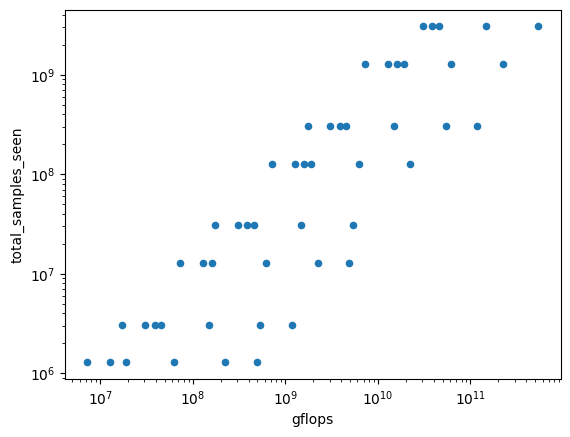

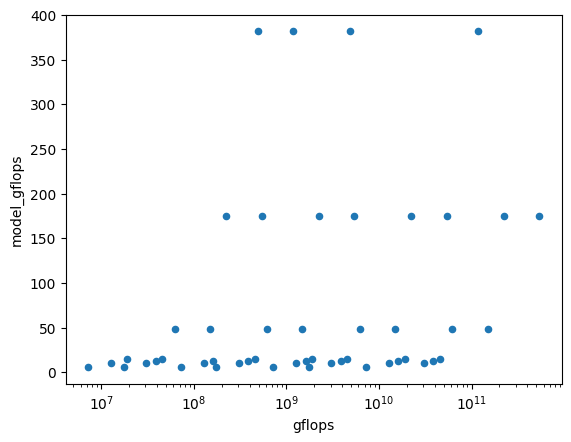

In [499]:

ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
#ds, metric = "imagenet1k", "contrastive_loss"
D = df.copy()
D = D[D.pretrain_dataset == "datacomp_1b"]
D = D[D.epoch==D.total_epochs]
D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
D = D[D.lr_scheduler == "cosine"]
D = D[D.namespace == "clip"]
gflops_grid = np.logspace(  np.log10(D.gflops_total.min()), np.log10(D.gflops_total.max()), 100)
D["model_gflops"] = D.apply(lambda d:model_profile.loc[d.model].gflops , axis=1)
rows = []
for start, end in zip(gflops_grid[0:-1], gflops_grid[1:]):
    d = D[(D.gflops_total >= start) & (D.gflops_total < end)]
    if len(d):        
        di = d.iloc[d[metric].argmax()]
        rows.append({
            "gflops": di.gflops_total,
            "err":1-di[metric],
            "model": di.model,
            "model_mparams": model_profile.loc[di.model].mparams,
            "model_gflops": model_profile.loc[di.model].gflops,
            "total_samples_seen": di.total_samples_seen,
        })
df_envelope = pd.DataFrame(rows)
#df_envelope = df_envelope[df_envelope.err < 0.5]
#df_envelope = df_envelope.sort_values(by="gflops")
df_envelope.plot(x="gflops", y="total_samples_seen", kind="scatter", logx=True, logy=True)
df_envelope.plot(x="gflops", y="model_gflops", kind="scatter", logx=True, logy=False)

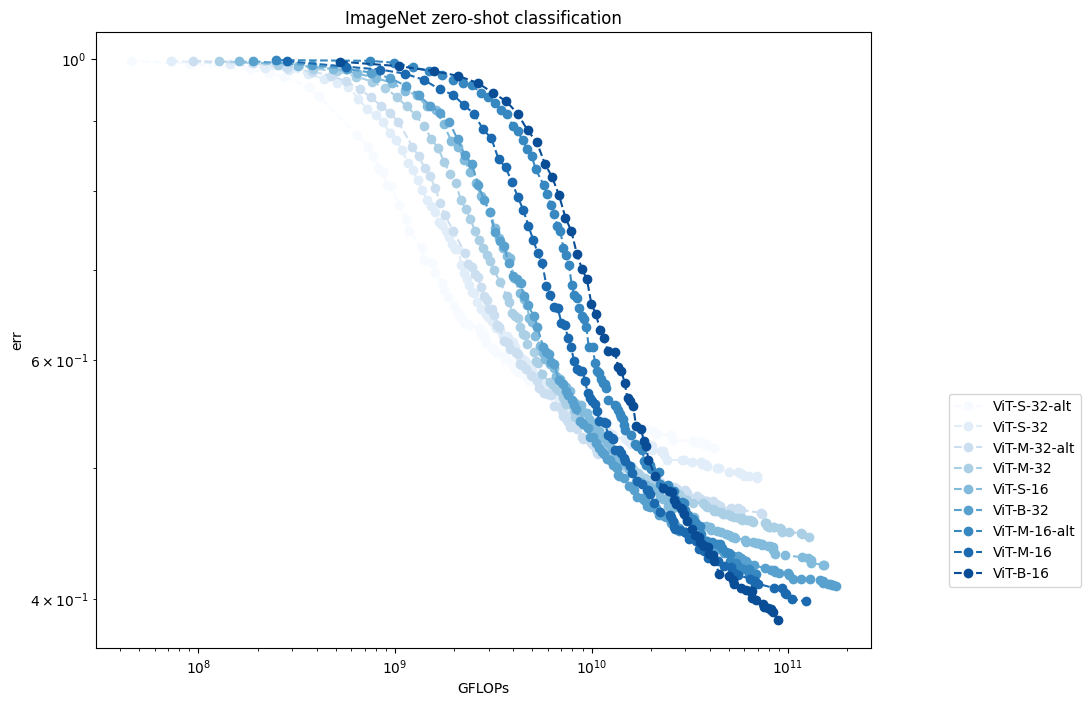

In [501]:
ds, metric = "imagenet1k", "acc1"
#ds, metric = "winoground", "text_acc"
#ds, metric = "sugar_crepe/swap_obj", "acc"
#ds, metric = "mscoco_captions", "image_retrieval_recall@5"
scheduler = "const"
D = df
D = D[D.pretrain_dataset == "datacomp_1b"]

D = D[D.downstream_dataset==ds]
D = D[~D[metric].isna()]
D = D[D.namespace == "clip"]
D = D[D.lr_scheduler == scheduler]
if scheduler != "const":
    D = D[D.epoch==D.total_epochs]
N = len(D.model.unique())
models = list(D.model.unique())
models = sorted(models, key=lambda k:model_profile.loc[k].gflops)
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
#for ind, (name, rows) in enumerate(D.groupby(["model"])):

for ind, model in enumerate(models):
    rows = D[D.model == model]
    name = rows.model.values[0]
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    if scheduler == "const":
        R["gflops_total"] = R.epoch * 12.8e6 * model_profile.loc[model].gflops
    R = R.sort_values(by="gflops_total")

    X = (R["gflops_total"]).values
    #X = R["total_samples_seen"].values
    Y = 1-(R[metric]).values


    #color = "blue"
    
    I+=1
    #m = (X>=10**9)# & (X < 10**12)
    #m = (X<10**12)
    #m = (X>0)  & (Y<1)
    m = X>0
    #print(np.unique(X))
    #for xi in np.unique(X):
    #    minval = Y[X==xi].min()
    #    Y[X==xi] = minval
    #m=(Y<=0.9) & (Y>0)

    #plt.plot(X[m], func(X[m]), label=f"{name}", linestyle='dashed', c=color)
    #m = monotonically_decreasing2(X, Y)
    #m = monotonically_decreasing(Y)
    #m = X>0
    #plt.scatter(X, Y, label=f"{name[0]}", c=color, s=10.0, alpha=0.5)
    XX, YY = group_vals(X, Y)
    m = monotonically_decreasing(YY)
    plt.plot(XX[m], YY[m], linestyle='dashed', c=cmap(  (I-1) / N), marker='o', label=f"{name}")
plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
plt.legend(loc=(1.1,.1))

#plt.legend()

if metric == "image_retrieval_recall@5":
    plt.title("COCO image retrieval recall@5")
    plt.savefig("coco_image_retrieval_5.pdf")
elif metric == "text_retrieval_recall@5":
    plt.title("COCO text retrieval recall@5")
    plt.savefig("coco_text_retrieval_5.pdf")
elif metric == "acc1":
    plt.title("ImageNet zero-shot classification")
    plt.savefig("imagenet.pdf")

plt.show()

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


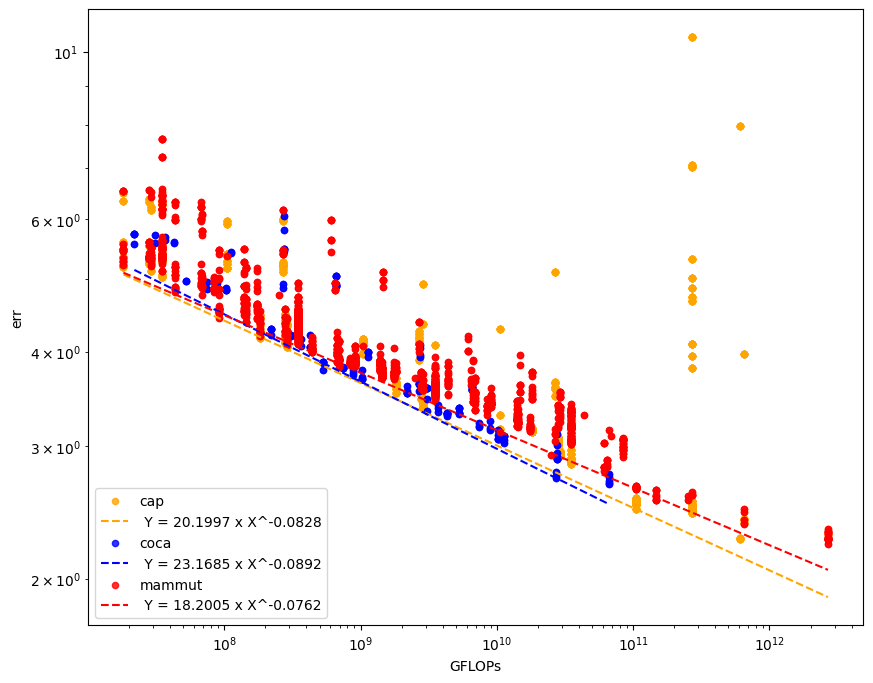

In [503]:
metric = "caption_loss"
D = df
D = D[D.pretrain_dataset == "datacomp_1b"]

D = D[D.epoch==D.total_epochs]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby("namespace")):  
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    #if "cap" in name:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = (R[metric]).values
    color = colors[I]
    I+=1
    #m = (X>=10**8) & (X < 10**12)
    #m = (X>0)  & (Y<1)
    #m = monotonically_decreasing(Y)
    m = X>0
    plt.scatter(X[m], Y[m], label=f"{name}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

plt.savefig(metric+".pdf")
plt.show()

QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')
QuantileRegressor(alpha=0, quantile=0.01, solver='highs-ds')


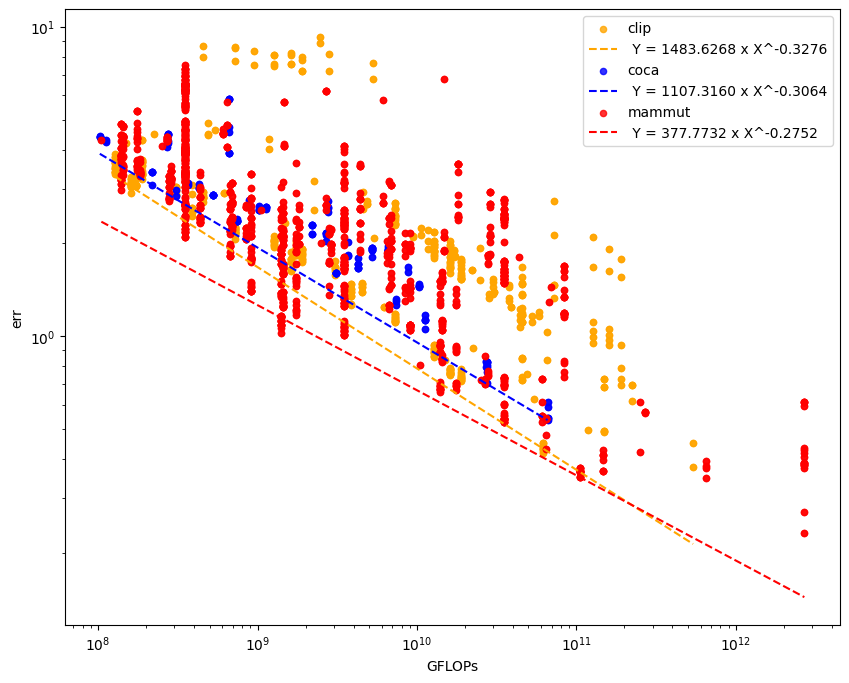

In [513]:
metric = "contrastive_loss"
D = df
D = D[D.epoch==D.total_epochs]
D = D[~D[metric].isna()]
colors = ["orange", "blue", "red", "green", "violet", "black"]
fig = plt.figure(figsize=(10, 8))
I=0
#print(D)
for ind, (name, rows) in enumerate(D.groupby("namespace")):  
    #if "generative"  in name[1]:
    #    continue
    #if "coca" in name[0]:
    #    continue
    #if "mammut" not in name[0]:
    #    continue
    #if "cap" in name:
    #    continue
    R = rows
    R = R[~R[metric].isna()]
    if len(R) == 0:
        continue
    if name == "cap":
        continue
    R = R.sort_values(by="gflops_total")
    X = (R["gflops_total"]).values
    Y = (R[metric]).values
    color = colors[I]
    I+=1
    m = (X>=10**8) #& (X < 10**12)
    #m = (X>0)  & (Y<1)
    #m = monotonically_decreasing(Y)
    plt.scatter(X[m], Y[m], label=f"{name}", c=color, s=20.0, alpha=0.8)
    #m=(Y<=0.9) & (Y>0)
    
    
    coefs, func, eq = curve_fit_powlaw_quantile(X[m], Y[m], q=0.01)    
    plt.plot(X[m], func(X[m]), label=f" {eq}", linestyle='dashed', c=color)

plt.xscale('log')
plt.yscale("log")

plt.xlabel("GFLOPs")
plt.ylabel("err")   
#plt.title(ds)
#plt.legend(loc=(1.1,.1))

plt.legend()

plt.savefig(metric+".pdf")
plt.show()